[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-reducers.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239428-lesson-2-state-reducers)

# State Reducers

## Review

We covered a few different ways to define LangGraph state schema, including `TypedDict`, `Pydantic`, or `Dataclasses`.

## Goals

Now, we're going to dive into reducers, which specify how state updates are performed on specific keys / channels in the state schema.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

## Default overwriting state

Let's use a `TypedDict` as our state schema.

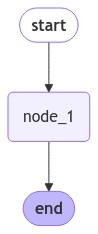

In [ ]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"foo" : 1})

---Node 1---


{'foo': 2}

Let's look at the state update, `return {"foo": state['foo'] + 1}`.

As discussed before, by default LangGraph doesn't know the preferred way to update the state.

So, it will just overwrite the value of `foo` in `node_1`:

```
return {"foo": state['foo'] + 1}
```

If we pass `{'foo': 1}` as input, the state returned from the graph is `{'foo': 2}`.

## Branching

Let's look at a case where our nodes branch.

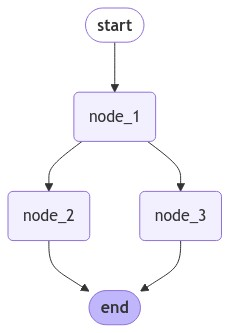

In [ ]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")


---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.


We see a problem!

Node 1 branches to nodes 2 and 3.

Nodes 2 and 3 run in parallel, which means they run in the same step of the graph.

They both attempt to overwrite the state *within the same step*.

This is ambiguous for the graph! Which state should it keep?

## Reducers

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) give us a general way to address this problem.

They specify how to perform updates.

We can use the `Annotated` type to specify a reducer function.

For example, in this case let's append the value returned from each node rather than overwriting them.

We just need a reducer that can perform this: `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

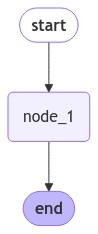

In [ ]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 2]}

Now, our state key `foo` is a list.

This `operator.add` reducer function will append updates from each node to this list.

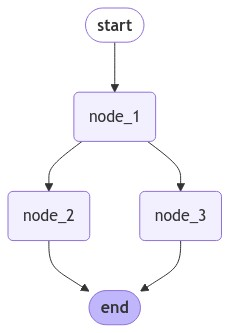

In [ ]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We can see that updates in nodes 2 and 3 are performed concurrently because they are in the same step.

In [ ]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

Now, let's see what happens if we pass `None` to `foo`.

We see an error because our reducer, `operator.add`, attempts to concatenate `NoneType` pass as input to list in `node_1`.

In [ ]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


## Custom Reducers

To address cases like this, [we can also define custom reducers](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state).

For example, lets define custom reducer logic to combine lists and handle cases where either or both of the inputs might be `None`.

In [ ]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

In `node_1`, we append the value 2.

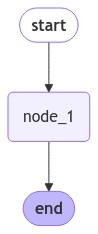

TypeError occurred: can only concatenate list (not "NoneType") to list


In [ ]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

Now, try with our custom reducer. We can see that no error is thrown.

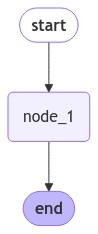

---Node 1---
{'foo': [2]}


In [ ]:
# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## Messages

In module 1, we showed how to use a built-in reducer, `add_messages`, to handle messages in state.

We also showed that [`MessagesState` is a useful shortcut if you want to work with messages](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate).

* `MessagesState` has a built-in `messages` key
* It also has a built-in `add_messages` reducer for this key

These two are equivalent.

We'll use the `MessagesState` class via `from langgraph.graph import MessagesState` for brevity.


In [ ]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# Define a custom TypedDict that includes a list of messages with add_messages reducer
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc

# Use MessagesState, which includes the messages key with add_messages reducer
class ExtendedMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    added_key_1: str
    added_key_2: str
    # etc

Let's talk a bit more about usage of the `add_messages` reducer.

In [ ]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', name='Model', id='f470d868-cf1b-45b2-ae16-48154cd55c12'),
 HumanMessage(content="I'm looking for information on marine biology.", name='Lance', id='a07a88c5-cb2a-4cbd-9485-5edb9d658366'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', name='Model', id='7938e615-86c2-4cbb-944b-c9b2342dee68')]

So we can see that `add_messages` allows us to append messages to the `messages` key in our state.

### Re-writing

Let's show some useful tricks when working with the `add_messages` reducer.

If we pass a message with the same ID as an existing one in our `messages` list, it will get overwritten!

In [ ]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", name='Lance', id='2')]

### Removal

`add_messages` also [enables message removal](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/).

For this, we simply use [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) from `langchain_core`.

In [ ]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', id='1'), RemoveMessage(content='', id='2')]


/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_17703/3097054180.py:10: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]


In [ ]:
add_messages(messages , delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', name='Lance', id='4')]

We can see that mesage IDs 1 and 2, as noted in `delete_messages` are removed by the reducer.

We'll see this put into practice a bit later.

# MY EXAMPLES:

# Default overwriting state:


Graph for Default Overwriting State:


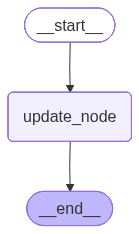

Initial state: {'message': 'Initial message', 'count': 10}
---Updating State Node---
Final state: {'message': 'Initial message', 'count': 15}


In [46]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display # Import Image and display

# 1. Define a new TypedDict for the state
class NewState(TypedDict):
    message: str
    count: int

# 2. Define a simple node function
def update_state_node(state: NewState) -> dict:
    print("---Updating State Node---")
    # 3. Inside the node function, update the value of one of the state keys
    # Do not include a reducer for this key in the state definition.
    updated_count = state['count'] + 5
    return {"count": updated_count}

# 4. Build a StateGraph with the new state definition and add the node
builder = StateGraph(NewState)
builder.add_node("update_node", update_state_node)

# 5. Add an edge from START to the node and from the node to END
builder.add_edge(START, "update_node")
builder.add_edge("update_node", END)

# 6. Compile the graph
graph = builder.compile()

# Display the graph
print("\nGraph for Default Overwriting State:")
display(Image(graph.get_graph().draw_mermaid_png()))

# 7. Invoke the compiled graph with an initial state
initial_state = {"message": "Initial message", "count": 10}
print(f"Initial state: {initial_state}")
result = graph.invoke(initial_state)

# 8. Print the output
print(f"Final state: {result}")

## Branching with default overwriting:



Graph for Branching (Conditional Edges):


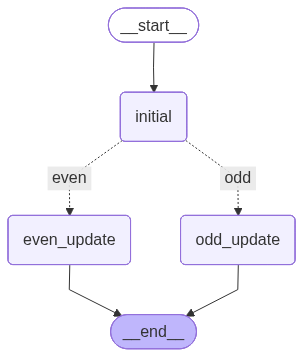


Graph for Branching (Parallel Update Conflict):


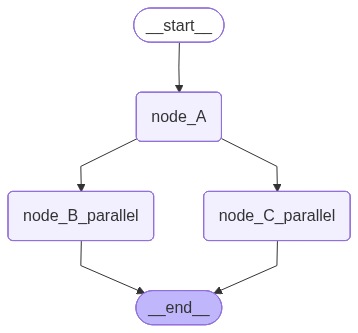

Attempting to invoke graph with initial state: {'value': 5}
---Node A---
---Node B (Parallel)---
---Node C (Parallel)---

Caught expected InvalidUpdateError: At key 'value': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


In [47]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.errors import InvalidUpdateError
from IPython.display import Image, display # Import Image and display


# 1. Define a new TypedDict for the state
class BranchingState(TypedDict):
    value: int
    branch_selector: str # Key to control branching

# 2. Define at least three node functions
def initial_node(state: BranchingState) -> dict:
    print("---Initial Node---")
    # Return a state update that leads to branching
    # Let's use the 'value' to determine the branch
    if state['value'] % 2 == 0:
        return {"branch_selector": "even"}
    else:
        return {"branch_selector": "odd"}

def even_node(state: BranchingState) -> dict:
    print("---Even Node---")
    # Attempt to update the same key 'value' using default overwriting
    return {"value": state['value'] + 10}

def odd_node(state: BranchingState) -> dict:
    print("---Odd Node---")
    # Attempt to update the same key 'value' using default overwriting
    return {"value": state['value'] + 20}

# Define a conditional edge function based on 'branch_selector'
def select_branch(state: BranchingState) -> str:
    return state.get("branch_selector", "") # Default to empty string if key not present

# 3. Build a StateGraph with the new state definition and add all the defined nodes
# Clearing previous edges and redefining for parallel execution from initial_node
builder = StateGraph(BranchingState) # Use BranchingState here
builder.add_node("initial", initial_node)
builder.add_node("even_update", even_node)
builder.add_node("odd_update", odd_node)

builder.add_edge(START, "initial")

# Conditional edge from initial_node to demonstrate branching, not parallel update conflict
builder.add_conditional_edges(
    "initial",    # From node
    select_branch, # Conditional edge function
    {             # Mapping of condition outcome to next node
        "even": "even_update",
        "odd": "odd_update",
    },
)

# Add edges from the branching nodes to END
builder.add_edge("even_update", END)
builder.add_edge("odd_update", END)

graph = builder.compile()

# Display the graph for the branching example
print("\nGraph for Branching (Conditional Edges):")
display(Image(graph.get_graph().draw_mermaid_png()))


# Now, let's create a graph that *will* cause the InvalidUpdateError for branching
class ConflictingState(TypedDict):
    value: int

def node_A(state: ConflictingState) -> dict:
    print("---Node A---")
    # Returns an update, but doesn't cause the branch directly by its return value
    # The branch will be defined by edges
    return {"value": state['value'] + 1}

def node_B_parallel(state: ConflictingState) -> dict:
    print("---Node B (Parallel)---")
    # Attempts to update the same key 'value' using default overwriting
    return {"value": state['value'] + 10}

def node_C_parallel(state: ConflictingState) -> dict:
    print("---Node C (Parallel)---")
    # Attempts to update the same key 'value' using default overwriting
    return {"value": state['value'] + 20}

# Build graph for parallel update conflict
builder = StateGraph(ConflictingState)
builder.add_node("node_A", node_A)
builder.add_node("node_B_parallel", node_B_parallel)
builder.add_node("node_C_parallel", node_C_parallel)

# Logic: Node A branches to Node B and Node C, causing parallel execution of B and C
builder.add_edge(START, "node_A")
builder.add_edge("node_A", "node_B_parallel")
builder.add_edge("node_A", "node_C_parallel") # This creates the branching that leads to parallel execution of B and C

# Add edges from the parallel nodes to END
builder.add_edge("node_B_parallel", END)
builder.add_edge("node_C_parallel", END)

# 6. Compile the graph
graph = builder.compile()

# Display the graph for the conflicting parallel update example
print("\nGraph for Branching (Parallel Update Conflict):")
display(Image(graph.get_graph().draw_mermaid_png()))


# 7. Use a try...except InvalidUpdateError block to invoke the compiled graph
initial_state = {"value": 5}
print(f"Attempting to invoke graph with initial state: {initial_state}")

try:
    graph.invoke(initial_state)
except InvalidUpdateError as e:
    # 8. Inside the except block, print the error message
    print(f"\nCaught expected InvalidUpdateError: {e}")

## Custom reducers example:



Graph for Custom Reducers:


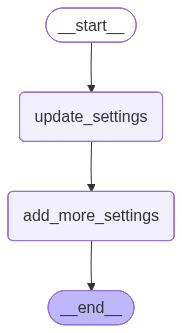

Initial state: {'settings': {'theme': 'light'}, 'status': 'initial', 'log': ['start']}
---Updating Settings Node---
---Adding More Settings Node---
Final state: {'settings': {'theme': 'dark', 'language': 'fr', 'notifications': 'off'}, 'status': 'settings_updated', 'log': ['start', 'settings updated', 'more settings added']}

Initial state (settings=None): {'settings': None, 'status': 'initial', 'log': ['start_none']}
---Updating Settings Node---
---Adding More Settings Node---
Final state (settings=None): {'settings': {'theme': 'dark', 'language': 'fr', 'notifications': 'off'}, 'status': 'settings_updated', 'log': ['start_none', 'settings updated', 'more settings added']}


In [48]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from operator import add
from IPython.display import Image, display # Import Image and display


# 1. Define a TypedDict for the state with at least one key annotated with a custom reducer.
# The key should hold a data structure other than a list or a simple integer/string (e.g., a dictionary).
def merge_dictionaries(left: dict | None, right: dict | None) -> dict:
    """Custom reducer to merge two dictionaries. Handles None inputs."""
    left = left if left is not None else {}
    right = right if right is not None else {}
    # Merge dictionaries, with values from 'right' overwriting values from 'left' in case of shared keys
    return {**left, **right}

class ComplexState(TypedDict):
    # Annotated key with the custom dictionary merging reducer
    settings: Annotated[dict[str, str], merge_dictionaries]
    status: str
    # Corrected reducer for the log key to use operator.add for list concatenation
    log: Annotated[list[str], add]

# 2. Define at least one node function that returns an update for the annotated state key.
def update_settings_node(state: ComplexState) -> dict:
    print("---Updating Settings Node---")
    # Return an update for the 'settings' dictionary and add a log entry
    new_settings = {"theme": "dark", "language": "en"}
    # Return a list for the log update so operator.add can concatenate it
    return {"settings": new_settings, "status": "settings_updated", "log": ["settings updated"]}

def add_more_settings_node(state: ComplexState) -> dict:
    print("---Adding More Settings Node---")
    # Return another update for the 'settings' dictionary
    more_settings = {"language": "fr", "notifications": "off"}
     # Return a list for the log update
    return {"settings": more_settings, "log": ["more settings added"]}


# 3. Build a StateGraph using the defined state and node(s).
builder = StateGraph(ComplexState)
builder.add_node("update_settings", update_settings_node)
builder.add_node("add_more_settings", add_more_settings_node)

# 4. Add appropriate edges to the graph (e.g., from START to the node, and from the node to END).
builder.add_edge(START, "update_settings")
builder.add_edge("update_settings", "add_more_settings") # Chain the nodes to see multiple updates
builder.add_edge("add_more_settings", END)

# 5. Compile the graph.
graph = builder.compile()

# Display the graph
print("\nGraph for Custom Reducers:")
display(Image(graph.get_graph().draw_mermaid_png()))

# 6. Invoke the compiled graph with an initial state that includes a value for the annotated key.
initial_state = {"settings": {"theme": "light"}, "status": "initial", "log": ["start"]}
print(f"Initial state: {initial_state}")
result = graph.invoke(initial_state)

# 8. Print the output of the graph invocation to demonstrate the effect of the custom reducer on the state.
print(f"Final state: {result}")

# Invoke again with None for settings to show None handling
initial_state_none = {"settings": None, "status": "initial", "log": ["start_none"]}
print(f"\nInitial state (settings=None): {initial_state_none}")
result_none = graph.invoke(initial_state_none)
print(f"Final state (settings=None): {result_none}")

# Example with add_messages:


Graph for add_messages:


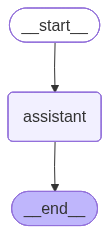

Initial messages: [HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={})]
---Assistant Node---
Final state: {'messages': [HumanMessage(content='Hello!', additional_kwargs={}, response_metadata={}, id='80c8e400-e848-430f-b3ea-74df7c363d2f'), AIMessage(content='How can I help you today?', additional_kwargs={}, response_metadata={}, id='9903ccc9-36f9-4b17-8e20-09abb2dd17da')]}


In [49]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import HumanMessage, AIMessage
from IPython.display import Image, display # Import Image and display

# 1. Define a node function that takes MessagesState as input and returns new messages
def assistant_node(state: MessagesState) -> MessagesState:
    print("---Assistant Node---")
    # The node returns a dictionary with the 'messages' key containing a list of new messages
    # The add_messages reducer will append these to the existing messages list in the state
    return {"messages": [AIMessage(content="How can I help you today?")]}

# 3. Build a StateGraph using MessagesState as the state definition
builder = StateGraph(MessagesState)

# 4. Add the defined node to the graph
builder.add_node("assistant", assistant_node)

# 5. Add an edge from START to the node and from the node to END
builder.add_edge(START, "assistant")
builder.add_edge("assistant", END)

# 6. Compile the graph
graph = builder.compile()

# Display the graph
print("\nGraph for add_messages:")
display(Image(graph.get_graph().draw_mermaid_png()))


# 7. Invoke the compiled graph with an initial state containing messages
initial_messages = [HumanMessage(content="Hello!")]
print(f"Initial messages: {initial_messages}")

result = graph.invoke({"messages": initial_messages})

# 8. Print the output of the graph invocation
print(f"Final state: {result}")

## Message overwriting with `add messages`



Initial messages: [HumanMessage(content='Initial query about topic A.', additional_kwargs={}, response_metadata={}, name='User1', id='msg_1'), AIMessage(content='Response to topic A.', additional_kwargs={}, response_metadata={}, name='AI1', id='msg_2'), HumanMessage(content='Initial query about topic B.', additional_kwargs={}, response_metadata={}, name='User2', id='msg_3')]
New messages to add: [AIMessage(content='Updated response to topic A.', additional_kwargs={}, response_metadata={}, name='AI1', id='msg_2'), HumanMessage(content='Follow-up question about topic C.', additional_kwargs={}, response_metadata={}, name='User3', id='msg_4')]
Combined messages after add_messages (demonstrating overwrite): [HumanMessage(content='Initial query about topic A.', additional_kwargs={}, response_metadata={}, name='User1', id='msg_1'), AIMessage(content='Updated response to topic A.', additional_kwargs={}, response_metadata={}, name='AI1', id='msg_2'), HumanMessage(content='Initial query about to

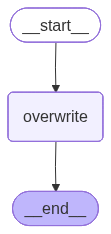

Invoking graph to demonstrate overwrite:
---Overwrite Node---
Final state after graph invocation: {'messages': [HumanMessage(content='Initial query about topic A.', additional_kwargs={}, response_metadata={}, name='User1', id='msg_1'), AIMessage(content='This message overwrites the initial AI message.', additional_kwargs={}, response_metadata={}, id='msg_2'), HumanMessage(content='Initial query about topic B.', additional_kwargs={}, response_metadata={}, name='User2', id='msg_3')]}


In [45]:
# 1. Import necessary classes: add_messages, AIMessage, HumanMessage.
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from IPython.display import Image, display # Import Image and display

# 2. Create an initial list of messages with unique IDs and some content.
initial_messages_overwrite = [
    HumanMessage(content="Initial query about topic A.", name="User1", id="msg_1"),
    AIMessage(content="Response to topic A.", name="AI1", id="msg_2"),
    HumanMessage(content="Initial query about topic B.", name="User2", id="msg_3"),
]
print(f"Initial messages: {initial_messages_overwrite}")

# 3. Create a new list of messages containing at least one message with an ID that matches an ID in the initial list, but with different content or attributes. Include at least one message with a new, unique ID.
new_messages_overwrite = [
    # This message has the same ID as the second message in initial_messages_overwrite
    AIMessage(content="Updated response to topic A.", name="AI1", id="msg_2"),
    # This message has a new, unique ID and should be appended.
    HumanMessage(content="Follow-up question about topic C.", name="User3", id="msg_4"),
]
print(f"New messages to add: {new_messages_overwrite}")

# 4. Call the add_messages function with the initial message list as the first argument and the new message list as the second argument.
combined_messages_overwrite = add_messages(initial_messages_overwrite, new_messages_overwrite)

# 5. Print the resulting message list to demonstrate that the message with the matching ID was overwritten and the message with the new ID was appended.
print(f"Combined messages after add_messages (demonstrating overwrite): {combined_messages_overwrite}")

# Add a simple graph to demonstrate message overwriting within a graph context
def overwrite_node(state: MessagesState) -> MessagesState:
    print("---Overwrite Node---")
    # Return a message with an existing ID to demonstrate overwriting
    return {"messages": [AIMessage(content="This message overwrites the initial AI message.", id="msg_2")]}

builder = StateGraph(MessagesState)
builder.add_node("overwrite", overwrite_node)
builder.add_edge(START, "overwrite")
builder.add_edge("overwrite", END)

graph_overwrite = builder.compile()

# Display the graph
print("\nGraph for Message Overwriting:")
display(Image(graph_overwrite.get_graph().draw_mermaid_png()))

# Invoke the graph with the initial messages
print("Invoking graph to demonstrate overwrite:")
result_overwrite_graph = graph_overwrite.invoke({"messages": initial_messages_overwrite})
print(f"Final state after graph invocation: {result_overwrite_graph}")

## Example for message removal:



Initial messages: [HumanMessage(content='First message.', additional_kwargs={}, response_metadata={}, name='UserA', id='msg_a'), AIMessage(content='Second message.', additional_kwargs={}, response_metadata={}, name='BotB', id='msg_b'), HumanMessage(content='Third message.', additional_kwargs={}, response_metadata={}, name='UserC', id='msg_c'), AIMessage(content='Fourth message.', additional_kwargs={}, response_metadata={}, name='BotD', id='msg_d')]
Messages to remove: [RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='msg_a'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='msg_c')]
Remaining messages after removal: [AIMessage(content='Second message.', additional_kwargs={}, response_metadata={}, name='BotB', id='msg_b'), AIMessage(content='Fourth message.', additional_kwargs={}, response_metadata={}, name='BotD', id='msg_d')]

Graph for Message Removal:


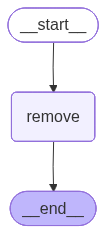

Invoking graph to demonstrate message removal:
---Remove Messages Node---
Final state after graph invocation: {'messages': [HumanMessage(content='First message.', additional_kwargs={}, response_metadata={}, name='UserA', id='msg_a'), HumanMessage(content='Third message.', additional_kwargs={}, response_metadata={}, name='UserC', id='msg_c'), AIMessage(content='Fourth message.', additional_kwargs={}, response_metadata={}, name='BotD', id='msg_d')]}


In [50]:
# 1. Import necessary classes: add_messages, AIMessage, HumanMessage, and RemoveMessage.
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage, RemoveMessage
from langgraph.graph import StateGraph, START, END, MessagesState # Import StateGraph and MessagesState
from IPython.display import Image, display # Import Image and display


# 2. Create an initial list of messages with unique IDs and some content.
initial_messages_remove = [
    HumanMessage(content="First message.", name="UserA", id="msg_a"),
    AIMessage(content="Second message.", name="BotB", id="msg_b"),
    HumanMessage(content="Third message.", name="UserC", id="msg_c"),
    AIMessage(content="Fourth message.", name="BotD", id="msg_d"),
]
print(f"Initial messages: {initial_messages_remove}")

# 3. Create a new list containing RemoveMessage instances for some of the IDs in the initial list.
# Let's remove the first and third messages (ids "msg_a" and "msg_c").
messages_to_remove = [
    RemoveMessage(id="msg_a"),
    RemoveMessage(id="msg_c"),
]
print(f"Messages to remove: {messages_to_remove}")

# 4. Call the add_messages function with the initial message list as the first argument and the list of RemoveMessage instances as the second argument.
remaining_messages = add_messages(initial_messages_remove, messages_to_remove)

# 5. Print the resulting message list to demonstrate that the messages with the specified IDs were removed.
print(f"Remaining messages after removal: {remaining_messages}")


# Add a simple graph to demonstrate message removal within a graph context
def remove_messages_node(state: MessagesState) -> MessagesState:
    print("---Remove Messages Node---")
    # Return a list of RemoveMessage instances to remove messages from the state
    return {"messages": [RemoveMessage(id="msg_b")]} # Remove the second message by ID

builder = StateGraph(MessagesState)
builder.add_node("remove", remove_messages_node)
builder.add_edge(START, "remove")
builder.add_edge("remove", END)

graph_remove = builder.compile()

# Display the graph
print("\nGraph for Message Removal:")
display(Image(graph_remove.get_graph().draw_mermaid_png()))

# Invoke the graph with the initial messages (before manual removal)
print("Invoking graph to demonstrate message removal:")
result_remove_graph = graph_remove.invoke({"messages": initial_messages_remove})
print(f"Final state after graph invocation: {result_remove_graph}")